In [41]:
%load_ext autoreload
%autoreload 1
from seispy.decon import RFTrace
import os

from matplotlib import pyplot as plt
import obspy
import pandas as pd

from insight.rotate import polarization_azimuth, angle_err
from insight.util import TraceFile, rf_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [42]:
DATA_DIR = "../data/"
network = "XB"
station = "ELYSE"
location = "02"
bandpass = {"freqmin": 0.1, "freqmax": 0.8}
before, after = 10, 120

## Read events back from disk

In [43]:
st_zne = {}
events = pd.read_parquet(os.path.join(DATA_DIR, "a_quality.parquet"))
for evt in events.index:
    trace_file = TraceFile(network, station, location, events.loc[evt].id)
    st_zne[evt] = obspy.read(os.path.join(DATA_DIR, "zne", str(trace_file)))

## Bandpass & DeTrend

In [44]:
for evt in events.index:
    st_zne[evt].detrend()
    st_zne[evt].filter(type="bandpass", **bandpass)

## Determine Polarisation

In [45]:
pa = {}

for evt in events.index:
    pa[evt] = polarization_azimuth(st_zne[evt], offset=before)._asdict()


In [46]:
events = events.join(pd.DataFrame(pa).T)
events["angle_err"] = events.apply(lambda e: angle_err(e.azimuth, float(e.mqs_azimuth)), axis=1)
events = events[events["angle_err"] < 10]
events

,id,region name,time,quality,mqs_azimuth,mqs_distance,est_p_arrival,M_w,azimuth,incident_angle,angle_err
earthquake name,,,,,,,,,,,
S1222a,mqs2022isne,Aeolis Northeast,2022-05-04T23:23:07.710516Z,A,109,37.01401401,2022-05-04T23:27:45.192771Z,4.6,118.284040,51.084036,9.284040
S0976a,mqs2021qpls,Coprates Northwest,2021-08-25T03:32:20.629953Z,A,101,146.2592593,2021-08-25T03:48:56.429772Z,4.3,99.504053,79.509641,1.495947
S1133c,mqs2022cixp,Elysium Southeast,2022-02-03T08:04:36.469259Z,A,90,30.00650651,2022-02-03T08:08:24.753506Z,3.8,88.681608,23.809977,1.318392
S0173a,mqs2019jzqa,Elysium Southeast,2019-05-23T02:19:09.852879Z,A,91,30.00650651,2019-05-23T02:22:58.043698Z,3.7,87.664478,31.754672,3.335522
S1048d,mqs2021vwbn,Elysium Southeast,2021-11-07T22:00:15.254098Z,A,100,30.18618619,2021-11-07T22:04:04.40886Z,3.6,96.483980,17.523525,3.516020
S0809a,mqs2021eppu,Elysium Southeast,2021-03-07T11:09:26.99714Z,A,87,29.82682683,2021-03-07T11:13:14.930832Z,3.3,87.011779,41.852616,0.011779


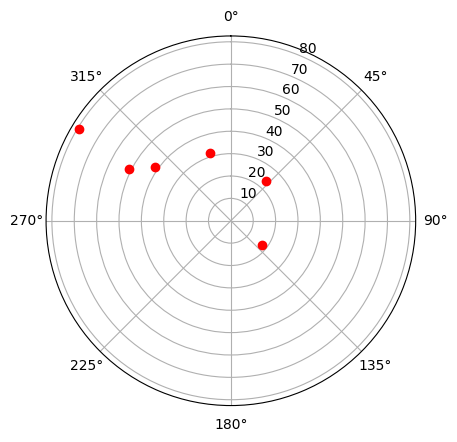

In [47]:
# Plot
ax = plt.subplot(111, polar=True)
ax.plot(events["azimuth"], events["incident_angle"], "ro")
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")

In [48]:
st_zrt = {}
for evt in events.index:
    st_zrt[evt] = st_zne[evt].copy().rotate(method="NE->RT", back_azimuth=events.loc[evt].azimuth)

In [49]:
prfs = {}
f0 = 2.0
itmax = 400
minderr = 0.001

for evt in events.index:
    prfs[evt] = RFTrace.deconvolute(
        st_zrt[evt][1], st_zrt[evt][2], method='iter',
        tshift=before, f0=f0, itmax=itmax,
        minderr=minderr)

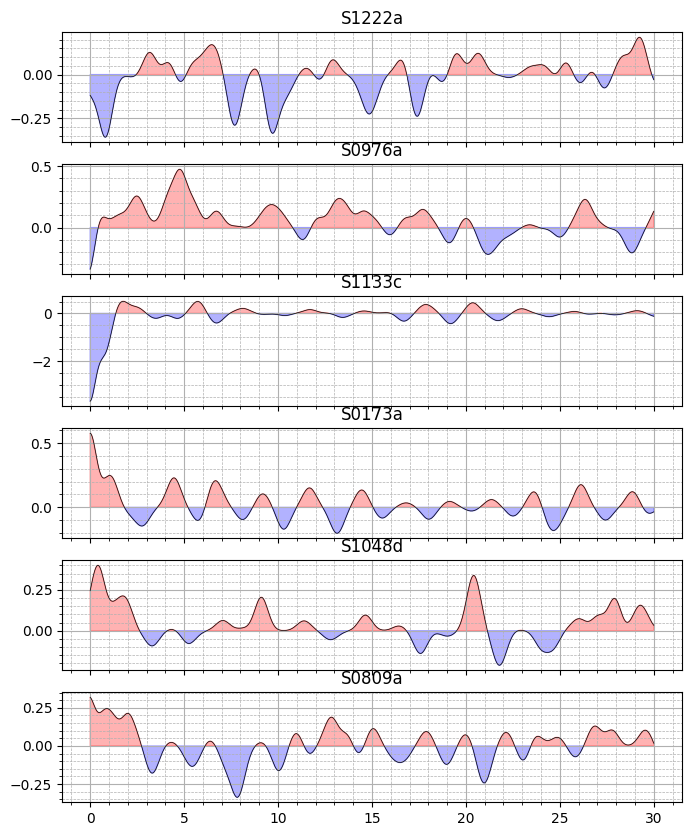

In [50]:
fig, axs = plt.subplots(len(events), 1, figsize=(8, 10), dpi=100, sharex=True)
# axs[0].set_ylim(-1, 1)
# axs[0].imshow(img, extent=(0, 25, -1, 1), aspect="auto")

i = 0
for evt in events.index:
    ax = axs[i]
    ax.set_title(evt)
    ax.grid(which="major")
    ax.grid(which="minor", linestyle="--", linewidth=.5)
    ax.minorticks_on()
    rf_plot(axs[i], prfs[evt])
    i += 1

In [51]:
st_lqt = {}
for evt in events.index:
    e = events.loc[evt]
    st_lqt[evt] = st_zne[evt].copy().rotate(method="ZNE->LQT", back_azimuth=e.azimuth,
                                            inclination=e.incident_angle)
    # st_lqt[evt].plot(type="relative")

In [52]:
prf2 = {}
for evt in events.index:
    prf2[evt] = RFTrace.deconvolute(
        st_zrt[evt][1], st_zrt[evt][2], method='iter',
        tshift=before, f0=f0, itmax=itmax,
        minderr=minderr)

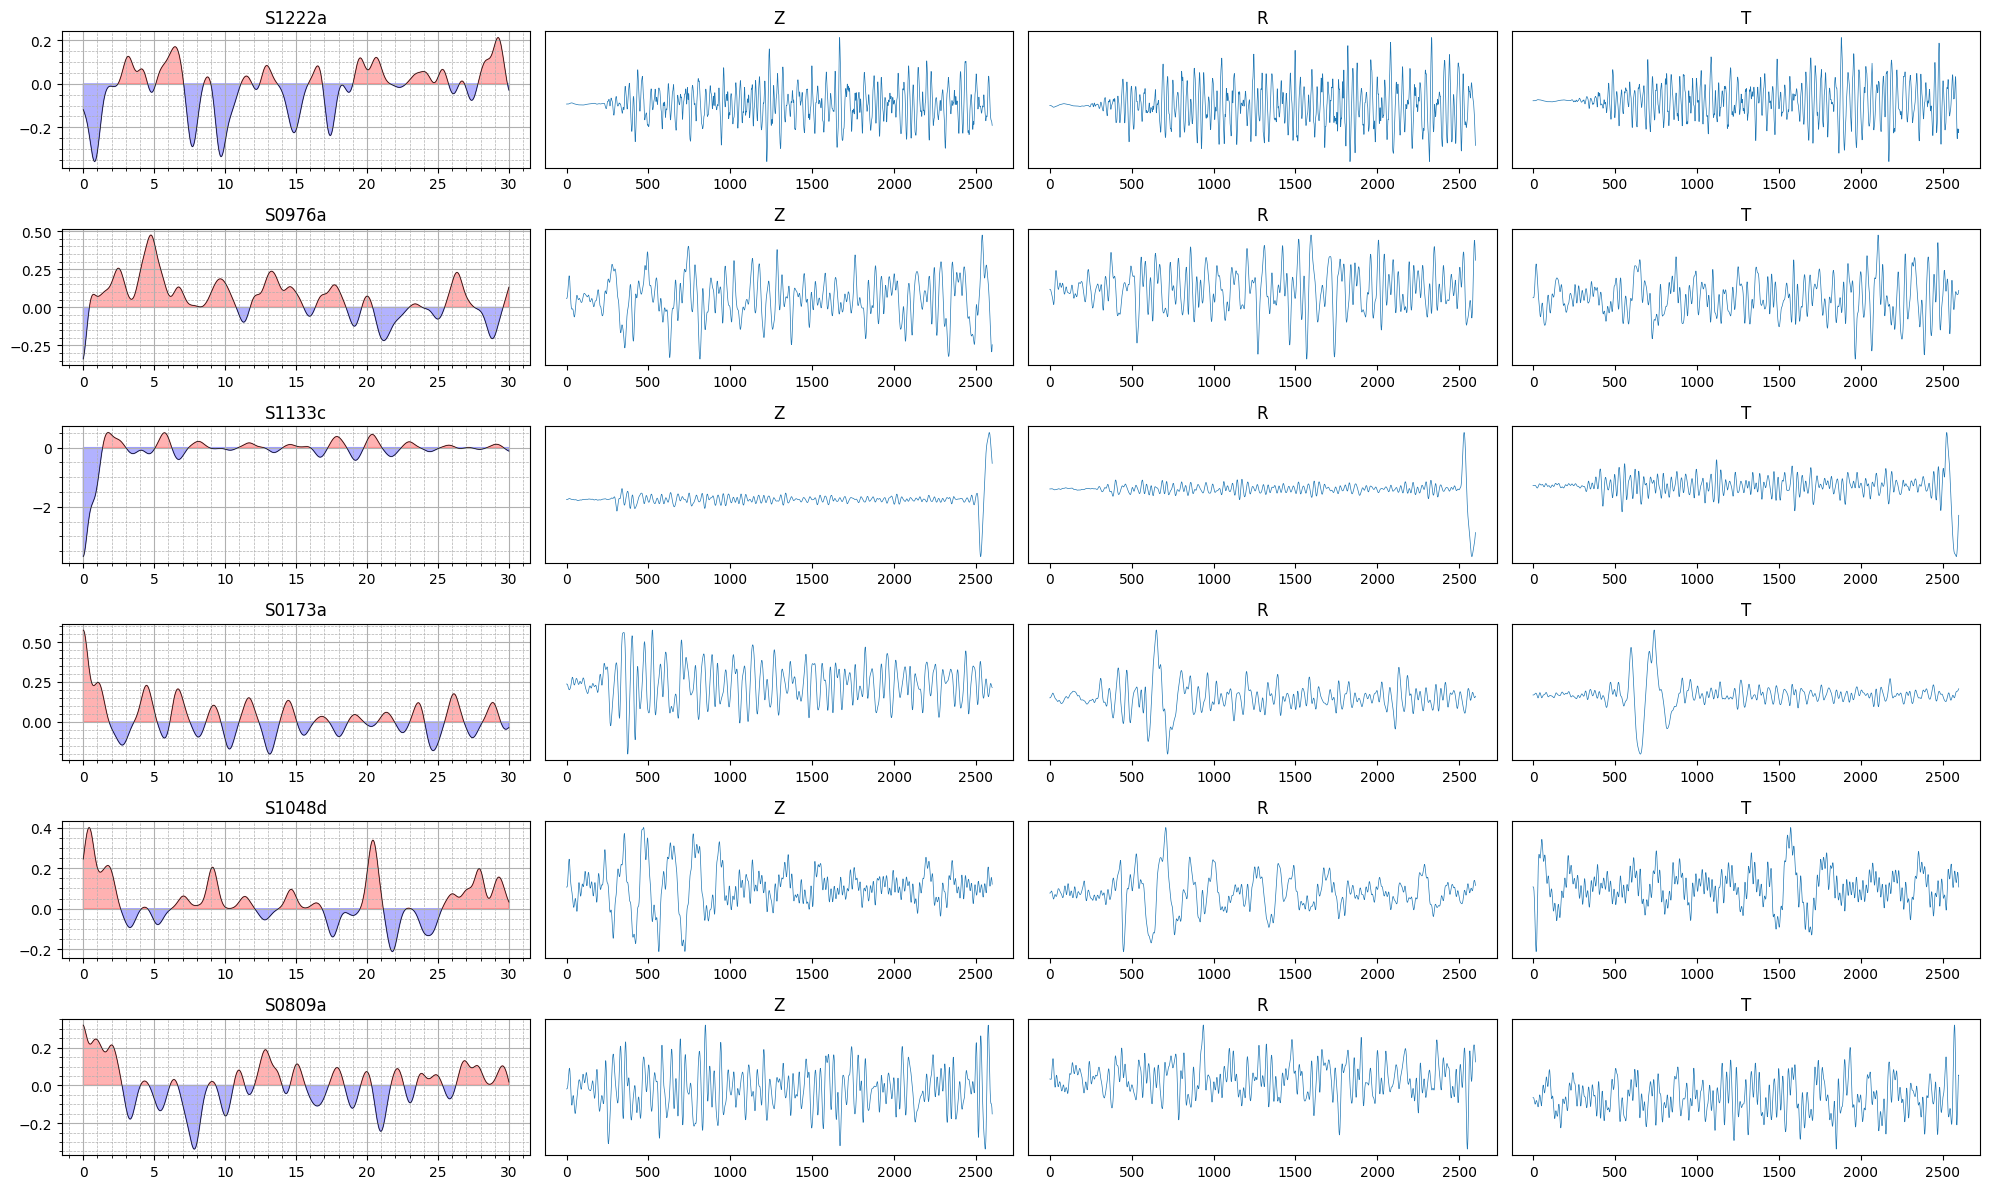

In [53]:
fig, axs = plt.subplots(len(events), 4, figsize=(20, 12), dpi=100)  #, sharex=True)

i = 0
for evt in events.index:
    ax = axs[i][0]
    ax.set_title(evt)
    ax.grid(which="major")
    ax.grid(which="minor", linestyle="--", linewidth=.5)
    ax.minorticks_on()
    rf_plot(ax, prf2[evt])
    for j in range(3):
        axs[i][j + 1].set_title("ZRT"[j])
        axs[i][j + 1].set_yticks([])
        axs[i][j + 1].plot(st_lqt[evt].traces[j].data, linewidth=.5)
    i += 1

fig.tight_layout()